In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Load dataset
df = pd.read_csv("Combined Data.csv")



# Lets Explore The Dataset(EDA)

In [2]:
df.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [3]:
df['status'].value_counts()

status
Normal                  16351
Depression              15404
Suicidal                10653
Anxiety                  3888
Bipolar                  2877
Stress                   2669
Personality disorder     1201
Name: count, dtype: int64

In [4]:
# Shape & datatypes
print("Dataset Shape:", df.shape)
print(df.info())

# Check nulls
print(df.isnull().sum())


Dataset Shape: (53043, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  53043 non-null  int64 
 1   statement   52681 non-null  object
 2   status      53043 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB
None
Unnamed: 0      0
statement     362
status          0
dtype: int64


In [5]:
#remove null values
df = df.dropna().reset_index(drop=True)


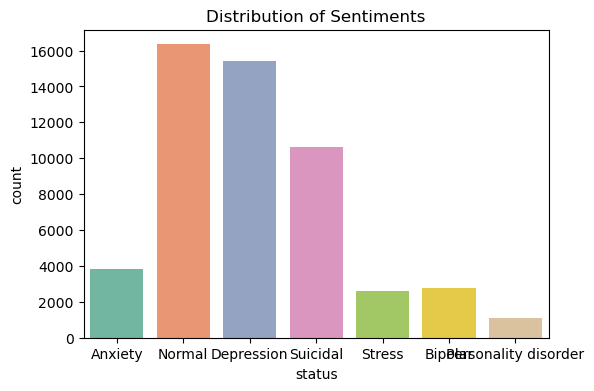

status
Normal                  0.310226
Depression              0.292401
Suicidal                0.202198
Anxiety                 0.072911
Bipolar                 0.052714
Stress                  0.049107
Personality disorder    0.020444
Name: proportion, dtype: float64


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sentiment counts
plt.figure(figsize=(6,4))
sns.countplot(x='status', data=df, palette="Set2")  # if column is 'label'
plt.title("Distribution of Sentiments")
plt.show()

print(df['status'].value_counts(normalize=True))


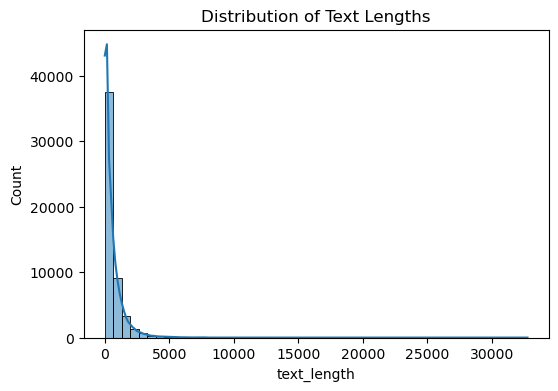

In [7]:
# Add column for text length
df['text_length'] = df['statement'].apply(len)

plt.figure(figsize=(6,4))
sns.histplot(df['text_length'], bins=50, kde=True)
plt.title("Distribution of Text Lengths")
plt.show()


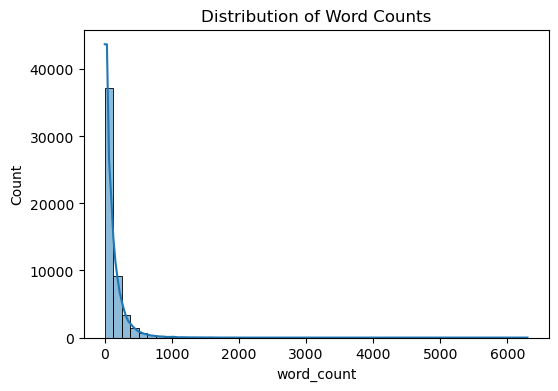

In [8]:
df['word_count'] = df['statement'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(6,4))
sns.histplot(df['word_count'], bins=50, kde=True)
plt.title("Distribution of Word Counts")
plt.show()


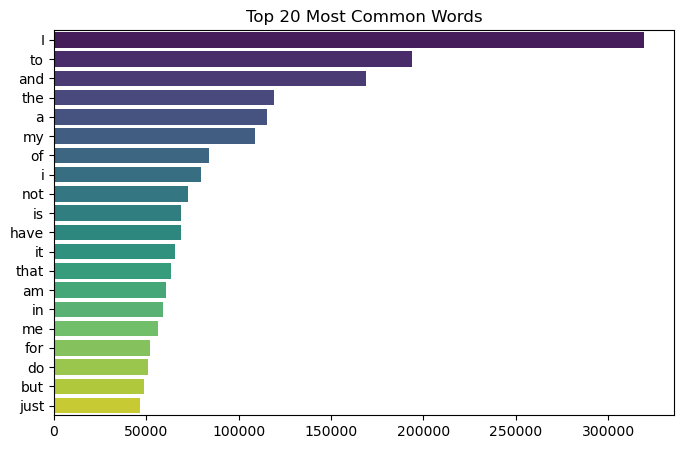

In [9]:
from collections import Counter

# Get most common words
words = " ".join(df['statement']).split()
common_words = Counter(words).most_common(20)

# Plot
plt.figure(figsize=(8,5))
sns.barplot(x=[w[1] for w in common_words], y=[w[0] for w in common_words], palette="viridis")
plt.title("Top 20 Most Common Words")
plt.show()


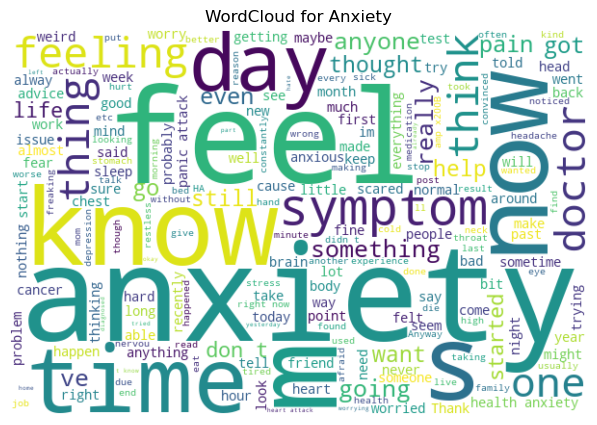

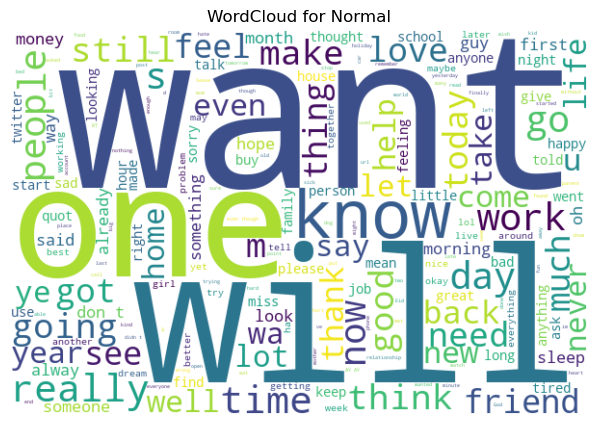

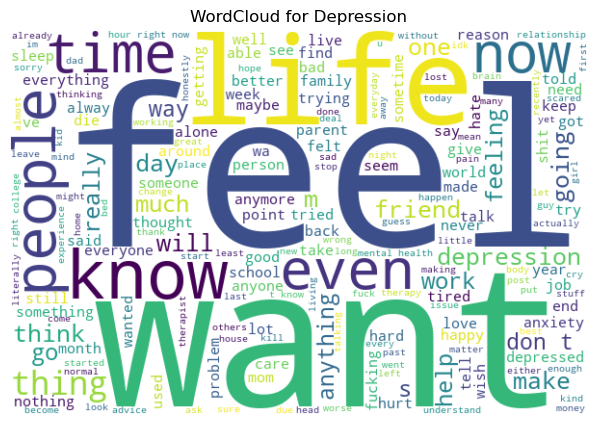

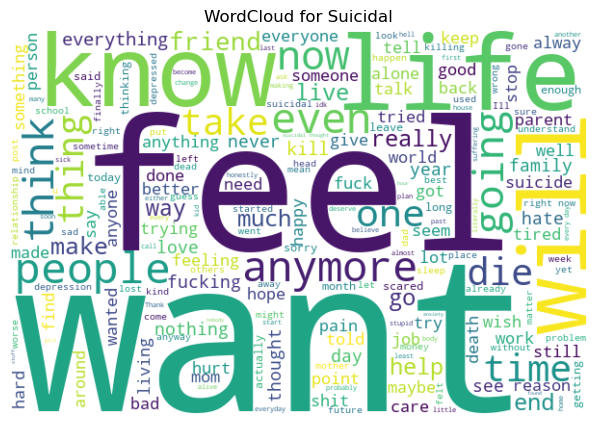

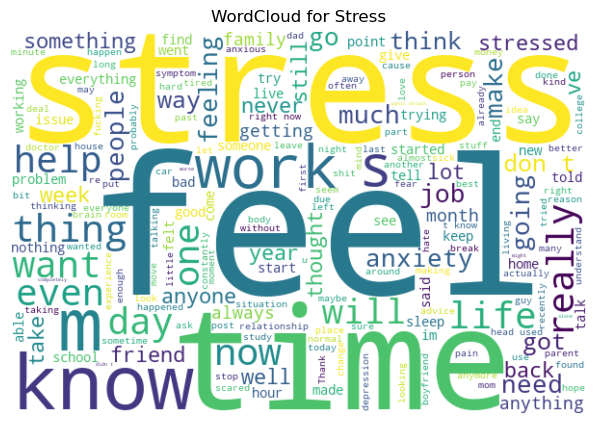

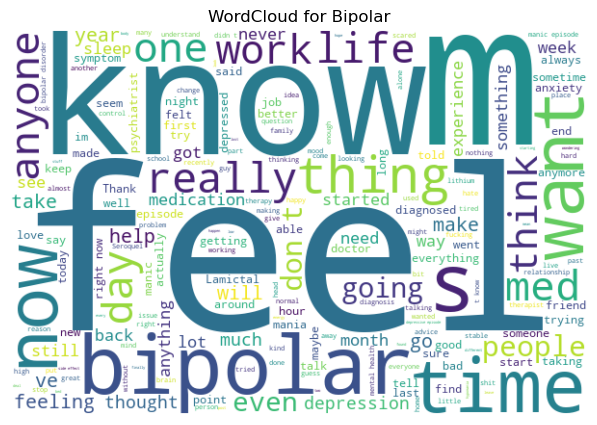

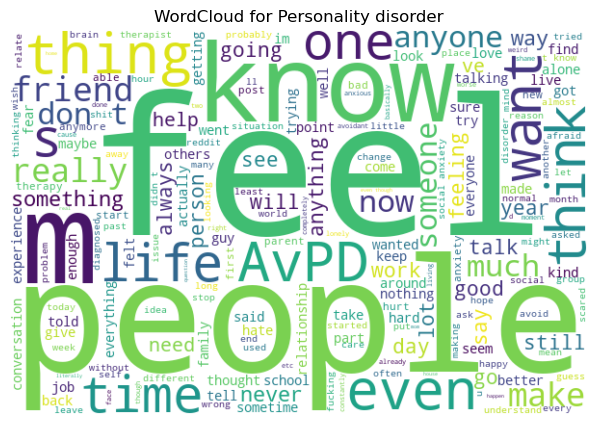

In [10]:
from wordcloud import WordCloud

for label in df['status'].unique():
    text_data = " ".join(df[df['status']==label]['statement'])
    wc = WordCloud(width=600, height=400, background_color="white").generate(text_data)

    plt.figure(figsize=(8,5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"WordCloud for {label}")
    plt.show()


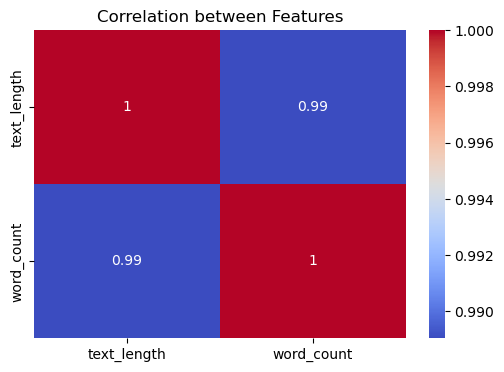

In [11]:
plt.figure(figsize=(6,4))
sns.heatmap(df[['text_length','word_count']].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation between Features")
plt.show()


## 🔤 Text Preprocessing: Tokenization & Train-Test Split

Before feeding our data into a neural network, we need to convert the raw text into a numerical format that the model can understand.  
This involves two important steps:

1. **Tokenization**  
   - Tokenization is the process of splitting text into smaller units (called *tokens*), usually words.  
   - We use Keras' `Tokenizer` to map each unique word in the dataset to an integer index.  
   - Example:  
     ```
     "I love deep learning" → [5, 12, 67, 89]
     ```

2. **Padding Sequences**  
   - Since sentences have different lengths, we pad them to ensure that all input sequences have the same length.  
   - This is crucial for batch processing in deep learning models.  
   - Example (max length = 100):  
     ```
     [5, 12, 67, 89] → [0, 0, 5, 12, 67, 89]
     ```

3. **Train-Test Split**  
   - To evaluate how well our model generalizes, we split the dataset into **training** and **testing** sets.  
   - The training set is used to fit the model, while the test set helps measure real-world performance.  

👉 After these steps, our text data is transformed into numerical tensors, ready to be fed into the RNN model.


In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2

# Encode labels
le = LabelEncoder()
df['status'] = le.fit_transform(df['status'])

X = df['statement'].astype(str)
y = df['status']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


# 2. Tokenization

max_words = 20000   # vocabulary size
max_len = 150       # sequence length

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

num_classes = len(le.classes_)


# 3. Load Pretrained GloVe Embeddings
# (Download glove.6B.100d.txt from Kaggle or GloVe website)

embedding_dim = 100
embeddings_index = {}

with open("glove.6B.100d.txt", encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coeffs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coeffs

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Build Model

In [13]:
# 4. Build Model
model = Sequential([
    Embedding(max_words, embedding_dim, input_length=max_len),
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# Training

In [14]:
# 6. Training
history = model.fit(
    X_train_pad, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_test_pad, y_test),
    verbose=1
)


Epoch 1/10
659/659 ━━━━━━━━━━━━━━━━━━━━ 167s 233ms/step - accuracy: 0.4963 - loss: 1.3228 - val_accuracy: 0.5690 - val_loss: 0.9877
Epoch 2/10
659/659 ━━━━━━━━━━━━━━━━━━━━ 153s 232ms/step - accuracy: 0.6110 - loss: 0.8712 - val_accuracy: 0.6389 - val_loss: 0.8106
Epoch 3/10
659/659 ━━━━━━━━━━━━━━━━━━━━ 142s 216ms/step - accuracy: 0.6980 - loss: 0.7117 - val_accuracy: 0.6961 - val_loss: 0.7671
Epoch 4/10
659/659 ━━━━━━━━━━━━━━━━━━━━ 141s 214ms/step - accuracy: 0.7629 - loss: 0.5983 - val_accuracy: 0.7286 - val_loss: 0.7099
Epoch 5/10
659/659 ━━━━━━━━━━━━━━━━━━━━ 143s 217ms/step - accuracy: 0.8103 - loss: 0.5014 - val_accuracy: 0.7542 - val_loss: 0.6710
Epoch 6/10
659/659 ━━━━━━━━━━━━━━━━━━━━ 158s 239ms/step - accuracy: 0.8450 - loss: 0.4195 - val_accuracy: 0.7556 - val_loss: 0.6813
Epoch 7/10
659/659 ━━━━━━━━━━━━━━━━━━━━ 158s 240ms/step - accuracy: 0.8675 - loss: 0.3607 - val_accuracy: 0.7535 - val_loss: 0.7109
Epoch 8/10
659/659 ━━━━━━━━━━━━━━━━━━━━ 158s 240ms/step - accuracy: 0.8941 -

# Evaluate model

In [23]:
# 7. Evaluate
loss, acc = model.evaluate(X_test_pad, y_test, verbose=0)
print(f"Test Accuracy: {acc:.2f}")

Test Accuracy: 0.75


In [24]:
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate model
loss, acc = model.evaluate(X_test_pad, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {acc:.4f}")

# Predictions (handle multiclass properly)
y_pred_probs = model.predict(X_test_pad, verbose=0)

if y_pred_probs.shape[1] > 1:  # MULTI-CLASS
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1) if y_test.ndim > 1 else y_test
else:  # BINARY
    y_pred = (y_pred_probs > 0.5).astype(int).flatten()
    y_true = y_test if y_test.ndim == 1 else y_test.flatten()

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4))

# Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))


Test Loss: 0.8298
Test Accuracy: 0.7550

Classification Report:
              precision    recall  f1-score   support

           0     0.7368    0.7656    0.7510       768
           1     0.6997    0.7626    0.7298       556
           2     0.7362    0.6595    0.6958      3081
           3     0.9157    0.9107    0.9132      3269
           4     0.5225    0.5395    0.5309       215
           5     0.6131    0.5242    0.5652       517
           6     0.6294    0.7260    0.6742      2131

    accuracy                         0.7550     10537
   macro avg     0.6934    0.6983    0.6943     10537
weighted avg     0.7580    0.7550    0.7549     10537


Confusion Matrix:
[[ 588   52   34   40   11   41    2]
 [  29  424   41   14   20   25    3]
 [  43   54 2032   76   37   33  806]
 [  53   16   75 2977   11   51   86]
 [  10   28   21   16  116   19    5]
 [  70   28   44   77   18  271    9]
 [   5    4  513   51    9    2 1547]]


# prediction on sample sentiment on our model

In [29]:
def predict_sentiment(text):
    seq = tokenizer.texts_to_sequences([text])
    pad = pad_sequences(seq, maxlen=max_len, padding='post')
    pred = model.predict(pad, verbose=0)
    label = le.inverse_transform([np.argmax(pred)])
    return label[0]

print(predict_sentiment("I do not know where to go, or what to do, or who to call when I get like this. I feel like an asshole for not knowing what a sense of comfort is. Maybe covering myself in warm blankets mimics the feelings, I have seen that on a Reddit post before. Why is venting and talking about problems so much easier when no one knows your name? that is why I am here in the first place. Why is venting and talking about problems so much easier when no one knows your name?"))


Depression


# saving the model

In [30]:
#save the model 
model.save("sentiment_model.h5")
#also save the tokenizer


In [31]:
#save the tokenizer
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [32]:
# Save in native Keras format
model.save("sentiment_model.keras")


In [33]:
import numpy as np
import joblib
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences   # ✅ Fix

# Load model
model = load_model("sentiment_model.keras")

# Load tokenizer
tokenizer = joblib.load("tokenizer.pickle")

# Load label encoder
le = joblib.load("labelencoder.pickle")

def predict_sentiment(text):
    seq = tokenizer.texts_to_sequences([text])
    pad = pad_sequences(seq, maxlen=150)  # use same maxlen as training
    pred = model.predict(pad, verbose=0)
    label = le.inverse_transform([np.argmax(pred)])
    return label[0]

print(predict_sentiment("I'm so restless, I don't know why"))


Normal


In [34]:
#save the labelencoder
import pickle
with open('labelencoder.pickle', 'wb') as handle:
    pickle.dump(le, handle, protocol=pickle.HIGHEST_PROTOCOL)